In [11]:
# ---------------- Data Loading ----------------
import pandas as pd
import cv2, os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paths (place english.csv and images.zip in /content via Colab Files)
csv_path = "english.csv"
zip_path = "images.zip"

# Unzip images
!unzip -o {zip_path} -d images_folder > /dev/null 2>&1

# Path to images
path = "images_folder/"

# Load CSV
df = pd.read_csv(csv_path)

IMG_SIZE = 28  # Resize to 28x28

# Character set (0-9, A-Z, a-z → total 62 classes)
classes = sorted(df['label'].unique())
label_map = {cls: idx for idx, cls in enumerate(classes)}

# Load images
X, y = [], []
for _, row in df.iterrows():
    img_path = os.path.join(path, row['image'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img.flatten())
    y.append(label_map[row['label']])

X = np.array(X) / 255.0   # normalize
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

print("Data loaded:", X_train.shape, y_train.shape, "Classes:", len(classes))

Data loaded: (2728, 784) (2728,) Classes: 62


In [12]:
# ---------------- Perceptron (PLA) - Multi-class One-vs-Rest ----------------
from sklearn.metrics import accuracy_score

class OneVsRestPLA:
    def __init__(self, n_classes, n_features, lr=0.01, epochs=10):
        self.n_classes = n_classes
        self.lr = lr
        self.epochs = epochs
        self.W = np.zeros((n_classes, n_features + 1))  # +1 for bias

    def _augment(self, X):
        # Add bias term
        return np.hstack([X, np.ones((X.shape[0], 1))])

    def fit(self, X, y):
        X_aug = self._augment(X)
        for _ in range(self.epochs):
            for i in range(X.shape[0]):
                xi, yi = X_aug[i], y[i]
                for k in range(self.n_classes):
                    t = 1 if yi == k else -1
                    yhat = 1 if np.dot(self.W[k], xi) >= 0 else -1
                    if t != yhat:
                        self.W[k] += self.lr * (t - yhat) * xi

    def predict(self, X):
        X_aug = self._augment(X)
        scores = np.dot(X_aug, self.W.T)
        return np.argmax(scores, axis=1)

# Train + evaluate PLA on all 62 classes
pla = OneVsRestPLA(n_classes=len(classes), n_features=X_train.shape[1], lr=0.01, epochs=5)
pla.fit(X_train, y_train)
y_pred_pla = pla.predict(X_test)

print("PLA Accuracy (62 classes):", accuracy_score(y_test, y_pred_pla))


PLA Accuracy (62 classes): 0.06304985337243402


In [13]:
# ---------------- Multilayer Perceptron (MLP) ----------------
import tensorflow as tf
from tensorflow.keras import layers, models

def build_mlp(hidden_units=128, activation='relu', optimizer='adam', lr=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(hidden_units, activation=activation))
    model.add(layers.Dense(len(label_map), activation='softmax'))

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
        opt = optimizer

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp = build_mlp(hidden_units=256, activation='relu', optimizer='adam', lr=0.001)
history_main = mlp.fit(X_train, y_train_cat, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

loss, acc = mlp.evaluate(X_test, y_test_cat, verbose=0)
print("MLP Accuracy:", acc)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0117 - loss: 4.3705 - val_accuracy: 0.0201 - val_loss: 4.1554
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0321 - loss: 4.1159 - val_accuracy: 0.0366 - val_loss: 4.1165
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0264 - loss: 4.0992 - val_accuracy: 0.0128 - val_loss: 4.1116
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0308 - loss: 4.0832 - val_accuracy: 0.0275 - val_loss: 4.0947
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0329 - loss: 4.0652 - val_accuracy: 0.0220 - val_loss: 4.0582
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0444 - loss: 4.0264 - val_accuracy: 0.0256 - val_loss: 4.0249
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0519 - loss: 3.9725 - val_accuracy: 0.0220 - val_loss: 3.9944
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0459 - loss: 3.9581 - val_accuracy: 0.0403 - val_lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.17      0.07      0.10        15
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00        14
          16      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


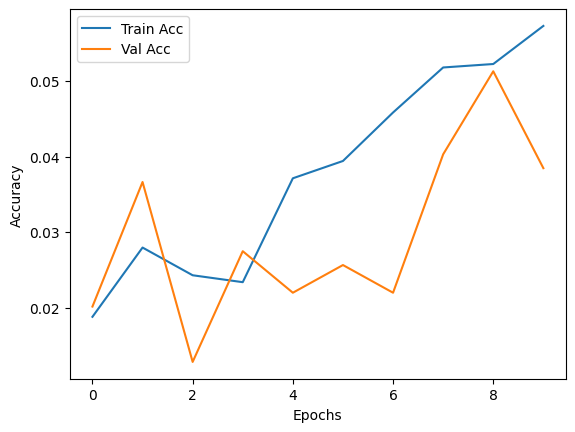

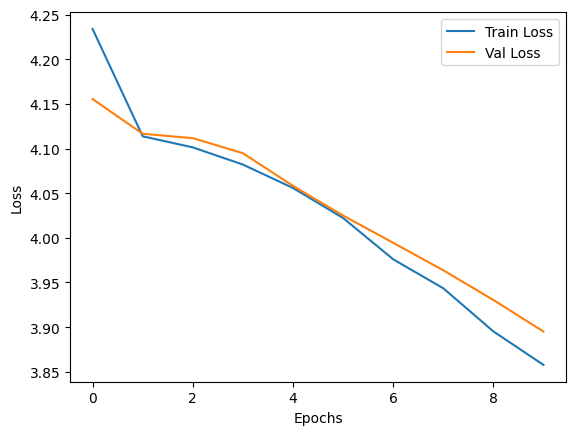

In [14]:
# ---------------- Evaluation ----------------
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

y_pred = mlp.predict(X_test).argmax(axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy curves
plt.plot(history_main.history['accuracy'], label='Train Acc')
plt.plot(history_main.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss curves
plt.plot(history_main.history['loss'], label='Train Loss')
plt.plot(history_main.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


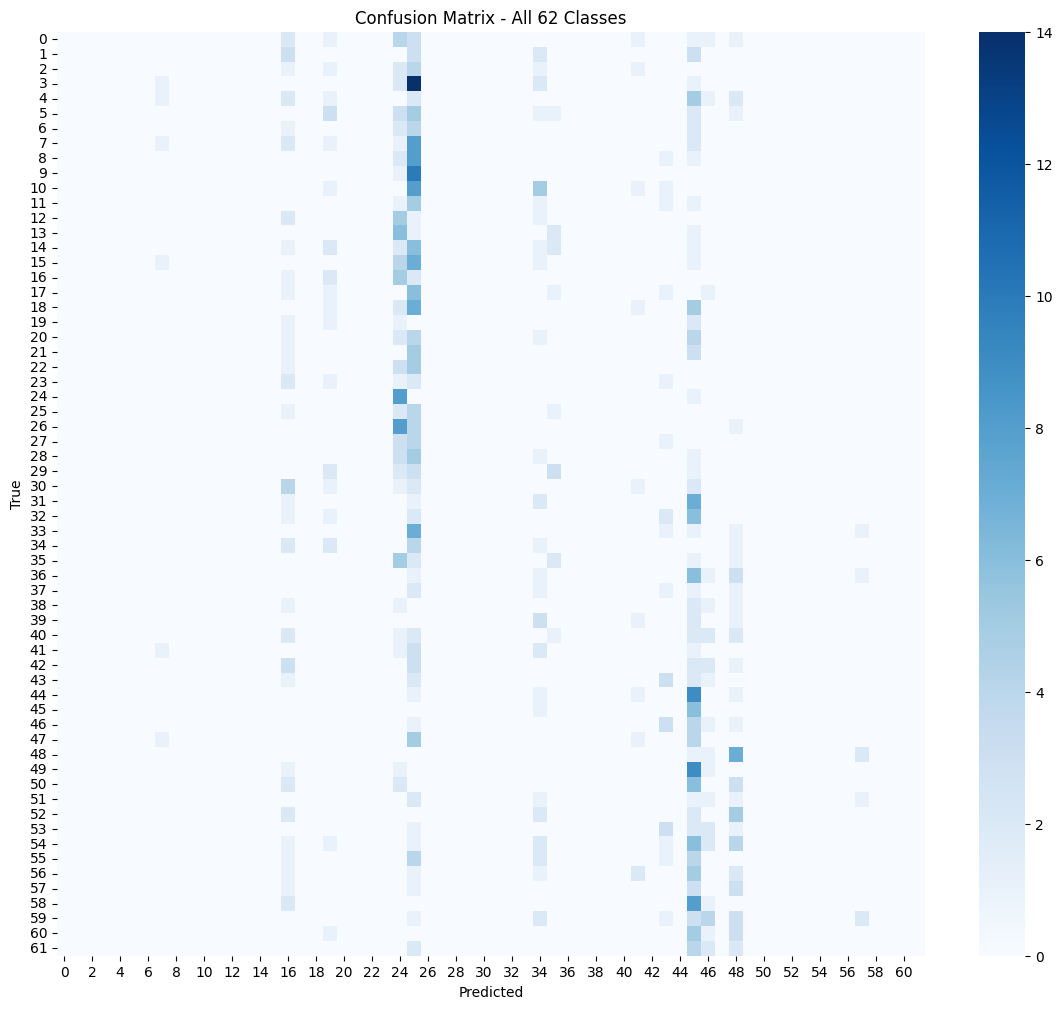

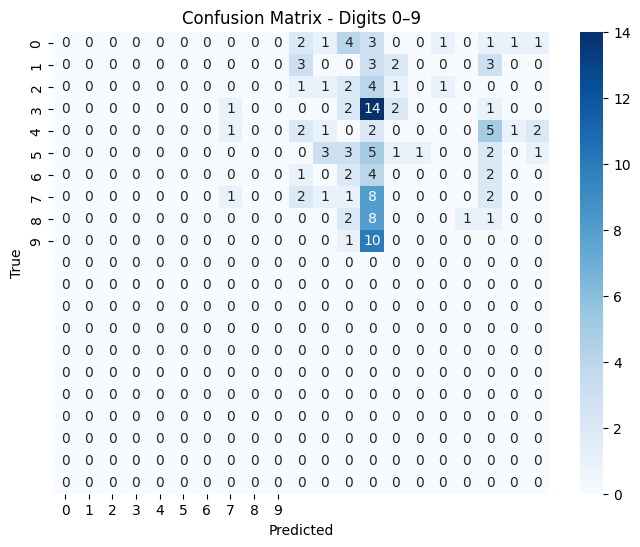

In [15]:
import seaborn as sns

# Full Confusion Matrix
cm_full = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_full, cmap="Blues")
plt.title("Confusion Matrix - All 62 Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Digits 0–9 Confusion Matrix
mask_digits = y_test < 10
cm_digits = confusion_matrix(y_test[mask_digits], y_pred[mask_digits])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_digits, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("Confusion Matrix - Digits 0–9")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


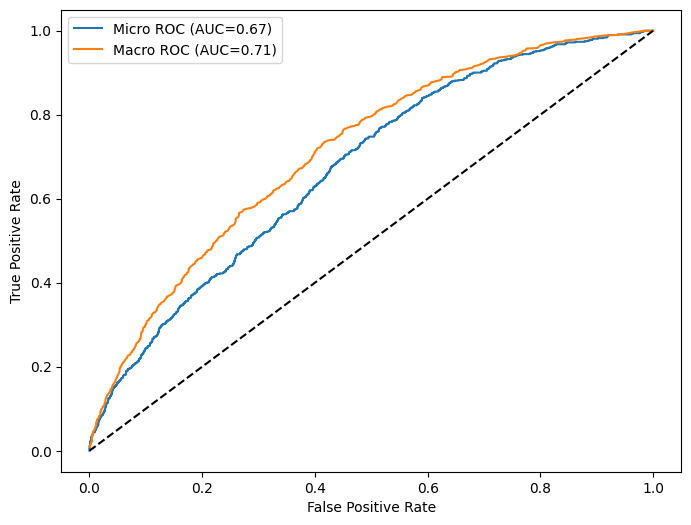

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize for multi-class ROC
y_test_bin = label_binarize(y_test, classes=list(range(len(classes))))
y_score = mlp.predict(X_test)

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= len(classes)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro ROC (AUC={roc_auc_micro:.2f})")
plt.plot(all_fpr, mean_tpr, label=f"Macro ROC (AUC={roc_auc_macro:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [18]:
print("\n--- A/B Experiment Comparison ---")
print(f"PLA Accuracy (62 classes): {accuracy_score(y_test, y_pred_pla):.2f}")
print(f"MLP Accuracy (62 classes): {acc:.2f}")
print("Final chosen hyperparameters for MLP: hidden_units=256, activation='relu', optimizer='adam', lr=0.001")

print("\nStrengths & Weaknesses:")
print("PLA → Simple, fast, works for multi-class using One-vs-Rest, but accuracy is low for 62 classes.")
print("MLP → Handles multi-class and non-linear data, needs tuning & more epochs.")

print("\nImpact of Hyperparameter Tuning:")
print(" - Different hidden units, activations, and optimizers affect accuracy.")
print(" - Current low PLA accuracy shows more epochs/layers would help.")



--- A/B Experiment Comparison ---
PLA Accuracy (62 classes): 0.06
MLP Accuracy (62 classes): 0.05
Final chosen hyperparameters for MLP: hidden_units=256, activation='relu', optimizer='adam', lr=0.001

Strengths & Weaknesses:
PLA → Simple, fast, works for multi-class using One-vs-Rest, but accuracy is low for 62 classes.
MLP → Handles multi-class and non-linear data, needs tuning & more epochs.

Impact of Hyperparameter Tuning:
 - Different hidden units, activations, and optimizers affect accuracy.
 - Current low PLA accuracy shows more epochs/layers would help.
